In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
train_path = "./Data/Data_src1/train"
valid_path = "./Data/Data_src1/valid"
test_path = "./Data/Data_src1/test"

In [3]:
# Transformaitions on training set 'image augmentation' - prevent overfitting (high accuracy on training set but not on test set) 
# ImageDataGenerator - generate batches of real time data (e.g. 32 images) - applies augmentation - e.g. zoom range, shear range, horizontal flip, rescale i.e. feature scaling (0-255 here)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# flow from directory connects to directory
# Resizing images to make the model faster
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 30250 images belonging to 2 classes.


In [4]:
# No transformations for test images, but requires feature scaling
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_set = validation_datagen.flow_from_directory(valid_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 6300 images belonging to 2 classes.


In [5]:
# No transformations for test images, but requires feature scaling
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 6300 images belonging to 2 classes.


CNN DEFINITION

In [ ]:
# Initializing
cnn = tf.keras.models.Sequential()

In [ ]:
# Convolution
# filters = kernels, activation = relu, input shape = 64x64, 3 (rgb)
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(64,64,3)))

In [ ]:
# Pooling
# Pool size = 2,2 (frame size), stride = 2 (# pixels frame shifts to right)
# padding = 'valid' (ignore) OR same (add empty pixels to make the frame complete)
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [ ]:
# Second convolutional layer
# No insput shape parameter required in second layer
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [ ]:
# Flattening
# Put results in 1D vector
cnn.add(tf.keras.layers.Flatten())

In [ ]:
# Full connection
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))

In [ ]:
# Output layer
cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

CNN TRAINING

In [ ]:
# compile - stochastic gradient optimizer - binary cross entropy loss - accuracy
cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# train and evaluate
cnn.fit(x=training_set, validation_data=validation_set, epochs=25)

In [ ]:
cnn.save('saved_model/cnn_25epochs_adam_bincross')

INFERENCE

In [6]:
training_set.class_indices

{'nowildfire': 0, 'wildfire': 1}

In [7]:
cnn = tf.keras.models.load_model('saved_model/cnn_25epochs_adam_bincross')

In [8]:
import numpy as np
import keras.utils as image

image_path=test_path+'/wildfire/-59.03238,51.85132.jpg'
test_image = image.load_img(image_path, target_size=(64,64)) #img size must be 64x64
test_image = image.img_to_array(test_image) #should be an array
test_image = np.expand_dims(test_image,axis=0) #must be an batch - so adding extra dimension
result = cnn.predict(test_image/255.0) #must normalize the test image

# inside a batch [0], first prediction [0]
if result[0][0] > 0.5:
    prediction = 'wildfire'
else:
    prediction = 'no wildfire'

1/1 [==============================] - 0s 334ms/step


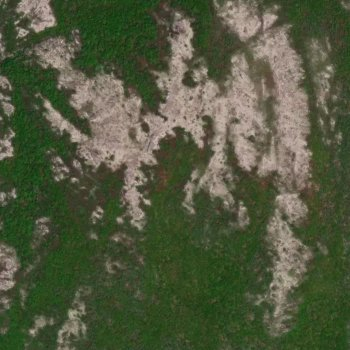

0.6248719
wildfire


In [9]:
from IPython.display import Image, display
display(Image(filename=image_path))
print(result[0][0])
print(prediction)

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
result = cnn.predict(test_set) 

197/197 [==============================] - 93s 476ms/step


In [12]:
print(result)

[[1.9307758e-13]
 [9.9643183e-01]
 [1.5443339e-16]
 ...
 [1.4439872e-16]
 [9.8271734e-01]
 [4.0868693e-12]]


In [19]:
import re

image_paths = test_set.filenames
results_disp = result[:5]
result_formatted = []

for i in range(len(result)):
    if result[i][0] >= 0.5:
        prediction_label = 'wildfire'
    else:
        prediction_label = 'no wildfire'

    result_obj = {
        "image_path": test_path + "/" + re.sub(r'\\', '/', image_paths[i]),
        "prediction": result[i],
        "prediction_label":prediction_label
    }
    
    # display(Image(filename=result_obj['image_path']))
    # print("Image Path:", result_obj['image_path'])
    # print("Prediction:", result_obj['prediction'])
    # print("Prediction Label:", result_obj['prediction_label'])

    result_formatted.append(result_obj)

In [29]:
type(result_formatted)

list

In [33]:
import pandas as pd
output_file = './model_predictions/cnn_25epochs_adam_bincross/result_formatted.csv'
df = pd.DataFrame(result_formatted)
df.to_csv(output_file)